### This is an example of the LULC (Land Use Land Cover) classification with python.
A Sentinel-2 image taken on 2021/02/21 is used for the input data. The image was resampled to have the same resolution (10 m) in all the bands by using the SNAP software. It is also possible to use the Sentinel-2 image without resampling, but you need to use a combination of bands with the same spatial resolution (ex: B8/B4/B3/B2 or B12/B11/B8A/B7/B6/B5).

In [2]:
#Import libraries
#Anaconda environment is strongly recommended.
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio as rio
import pyproj
from pyproj import Proj
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from PIL import Image

It is assumed that the training data are taken as a list of LULC codes and the locations of each point. In this case, the "Database.shp" file contains the necessary information of the classification. There are 700 training points I collected. <br>

The LULC codes are:<br>
0: Barren land <br>
1: Built up area <br>
2: Crop land <br>
3: Solar panel <br>
4: Vegetation <br>
5: Water <br>

In [3]:
#Read the training data by using geopandas.
#There are 700 training points I collected.
#LULC codes coresspond to the Land cover classes.
#LULC 1 ...
DataBase=gpd.read_file("...\...\DataBase.shp")
DataBase

,label,LULC,geometry
0,Pin 1,5,POINT (140.38279 35.98949)
1,Pin 2,2,POINT (140.31305 35.87466)
2,Pin 3,2,POINT (140.48388 35.99546)
3,Pin 4,2,POINT (140.47504 35.90425)
4,Pin 5,4,POINT (140.29947 35.98113)
...,...,...,...
695,Pin 696,3,POINT (140.28792 35.99656)
696,Pin 697,3,POINT (140.32477 35.99158)
697,Pin 698,3,POINT (140.36672 35.97091)
698,Pin 699,3,POINT (140.35633 35.94028)


We need to store the satellite image as a NumPy matrix. It is easy to do such works by using the rasterio library. If you're interested in it, please kindly refer to the official link. https://rasterio.readthedocs.io/en/latest/intro.html

In [4]:
#Put the path to the folder where the Sentinel-2 image is stored.
filepath="...\..." 

NumOfClasses=6

#This list will store the numpy form of the satellite images.
S2Image=[]
#List of band names that we want to use.
BandNames=["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]
#The number of bands.
NumOfBands=len(BandNames)

#Read and store the each band as a numpy array.
for Band in BandNames:
    ReadBand=rio.open(filepath+f"\S2A_20210221_resampled.data\{Band}.img")
    ReadBandArray=ReadBand.read(1)
    S2Image.append(ReadBandArray)

To apply the ML methods to the satellite image, it is necessary to get the input values at each training point. To do this job, we first convert the lat/lon of training points into the UTM coordinates because original Sentinel-2 products are projected in UTM. After knowing the UTM coordinates, it can easily be done to get the matrix coordinates with the help of rasterio.

In [5]:
#Get the necessary parameters to compute the UTM coordinates from the lat/lon.
proj=((Proj(f"{ReadBand.crs}").definition_string()).split()[0]).replace("proj=","")
zone=int(((Proj(f"{ReadBand.crs}").definition_string()).split()[1]).replace("zone=",""))
ellps=((Proj(f"{ReadBand.crs}").definition_string()).split()[2]).replace("datum=","")

#Prepare the conversion from lat/lon to UTM coordinates.
p=Proj(proj=proj,zone=zone,ellps=ellps, preserve_units=False)

N=len(DataBase["label"])

#This list will store the spectrum information at each training point.
spectrum_data=[]

for n in tqdm(range(N)):
    #Calculate the UTM coordinates
    UTMx,UTMy=p(DataBase["geometry"][n].x,DataBase["geometry"][n].y)
    #Calculate the matrix coordinates.
    x,y=ReadBand.index(UTMx,UTMy)
    pixel_coords_on_matrix=(x,y)
    #Read and store the spectrum information at the point (x,y) on the matrix for every band.
    spectrum_data_at_xy=[]
    for m in range(NumOfBands):
        spectrum_data_at_xy.append(S2Image[m][pixel_coords_on_matrix])
    spectrum_data.append(spectrum_data_at_xy)
        
DataBase["Spectrum_data"]=spectrum_data


100%|██████████████████████████████████████████████████████████████████████████████| 700/700 [00:00<00:00, 9745.16it/s]


The next step is to create training data and test data. Those data are made by using the usual splitting library. The number of training points varies from class to class. Therefore, 20% of data at each class will be used as the test data.

In [6]:
trainData=[]
trainLabel=[]
testData=[]
testLabel=[]

for i in range(NumOfClasses):
    Data_class_i=DataBase[DataBase["LULC"]==i]["Spectrum_data"]
    Labels_class_i=DataBase[DataBase["LULC"]==i]["LULC"]
    
    Data_train, Data_test, Label_train, Label_test = train_test_split(Data_class_i, Labels_class_i, test_size=0.2)
    
    trainData.extend(Data_train)
    trainLabel.extend(Label_train)
    testData.extend(Data_test)
    testLabel.extend(Label_test)


trainData=np.array(trainData)
testData=np.array(testData)
trainLabel=np.array(trainLabel)
testLabel=np.array(testLabel)

We are almost done! The only work we need to do is to train the model and apply it to the entire satellite image. First, we try to use the neural network as a classifier.

In [7]:
#Neural Network
#Two hidden layers with 250 nodes each.
#Two dropout layers were added to reduce the overfitting problems.

trainData_NN=np.array(trainData)
testData_NN=np.array(testData)
trainLabel_NN=keras.utils.to_categorical(trainLabel)
testLabel_NN=keras.utils.to_categorical(testLabel)

model=Sequential()
model.add(Dense(250,activation="relu",input_dim=12))
model.add(Dropout(0.1))
model.add(Dense(250,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6,activation="softmax"))

adam=Adam(lr=0.001)
model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=["accuracy"])

model.fit(trainData_NN,trainLabel_NN,epochs=500,batch_size=150,verbose=0)
loss,acc=model.evaluate(testData_NN,testLabel_NN)
print("The classification accuracy is {:.4f}".format(acc))


144/144 [==============================] - 0s 194us/step
The classification accuracy is 0.8403


The accuracy is not bad, so let's apply the classifier to the entire data. To make the processing faster, the classification takes a row as input then returns the classified results. This method is very much faster than the way of applying the classifier at each point. In my case, it took three hours to process the image when I applied the classifier at each point.

100%|██████████████████████████████████████████████████████████████████████████████| 2220/2220 [01:46<00:00, 20.89it/s]


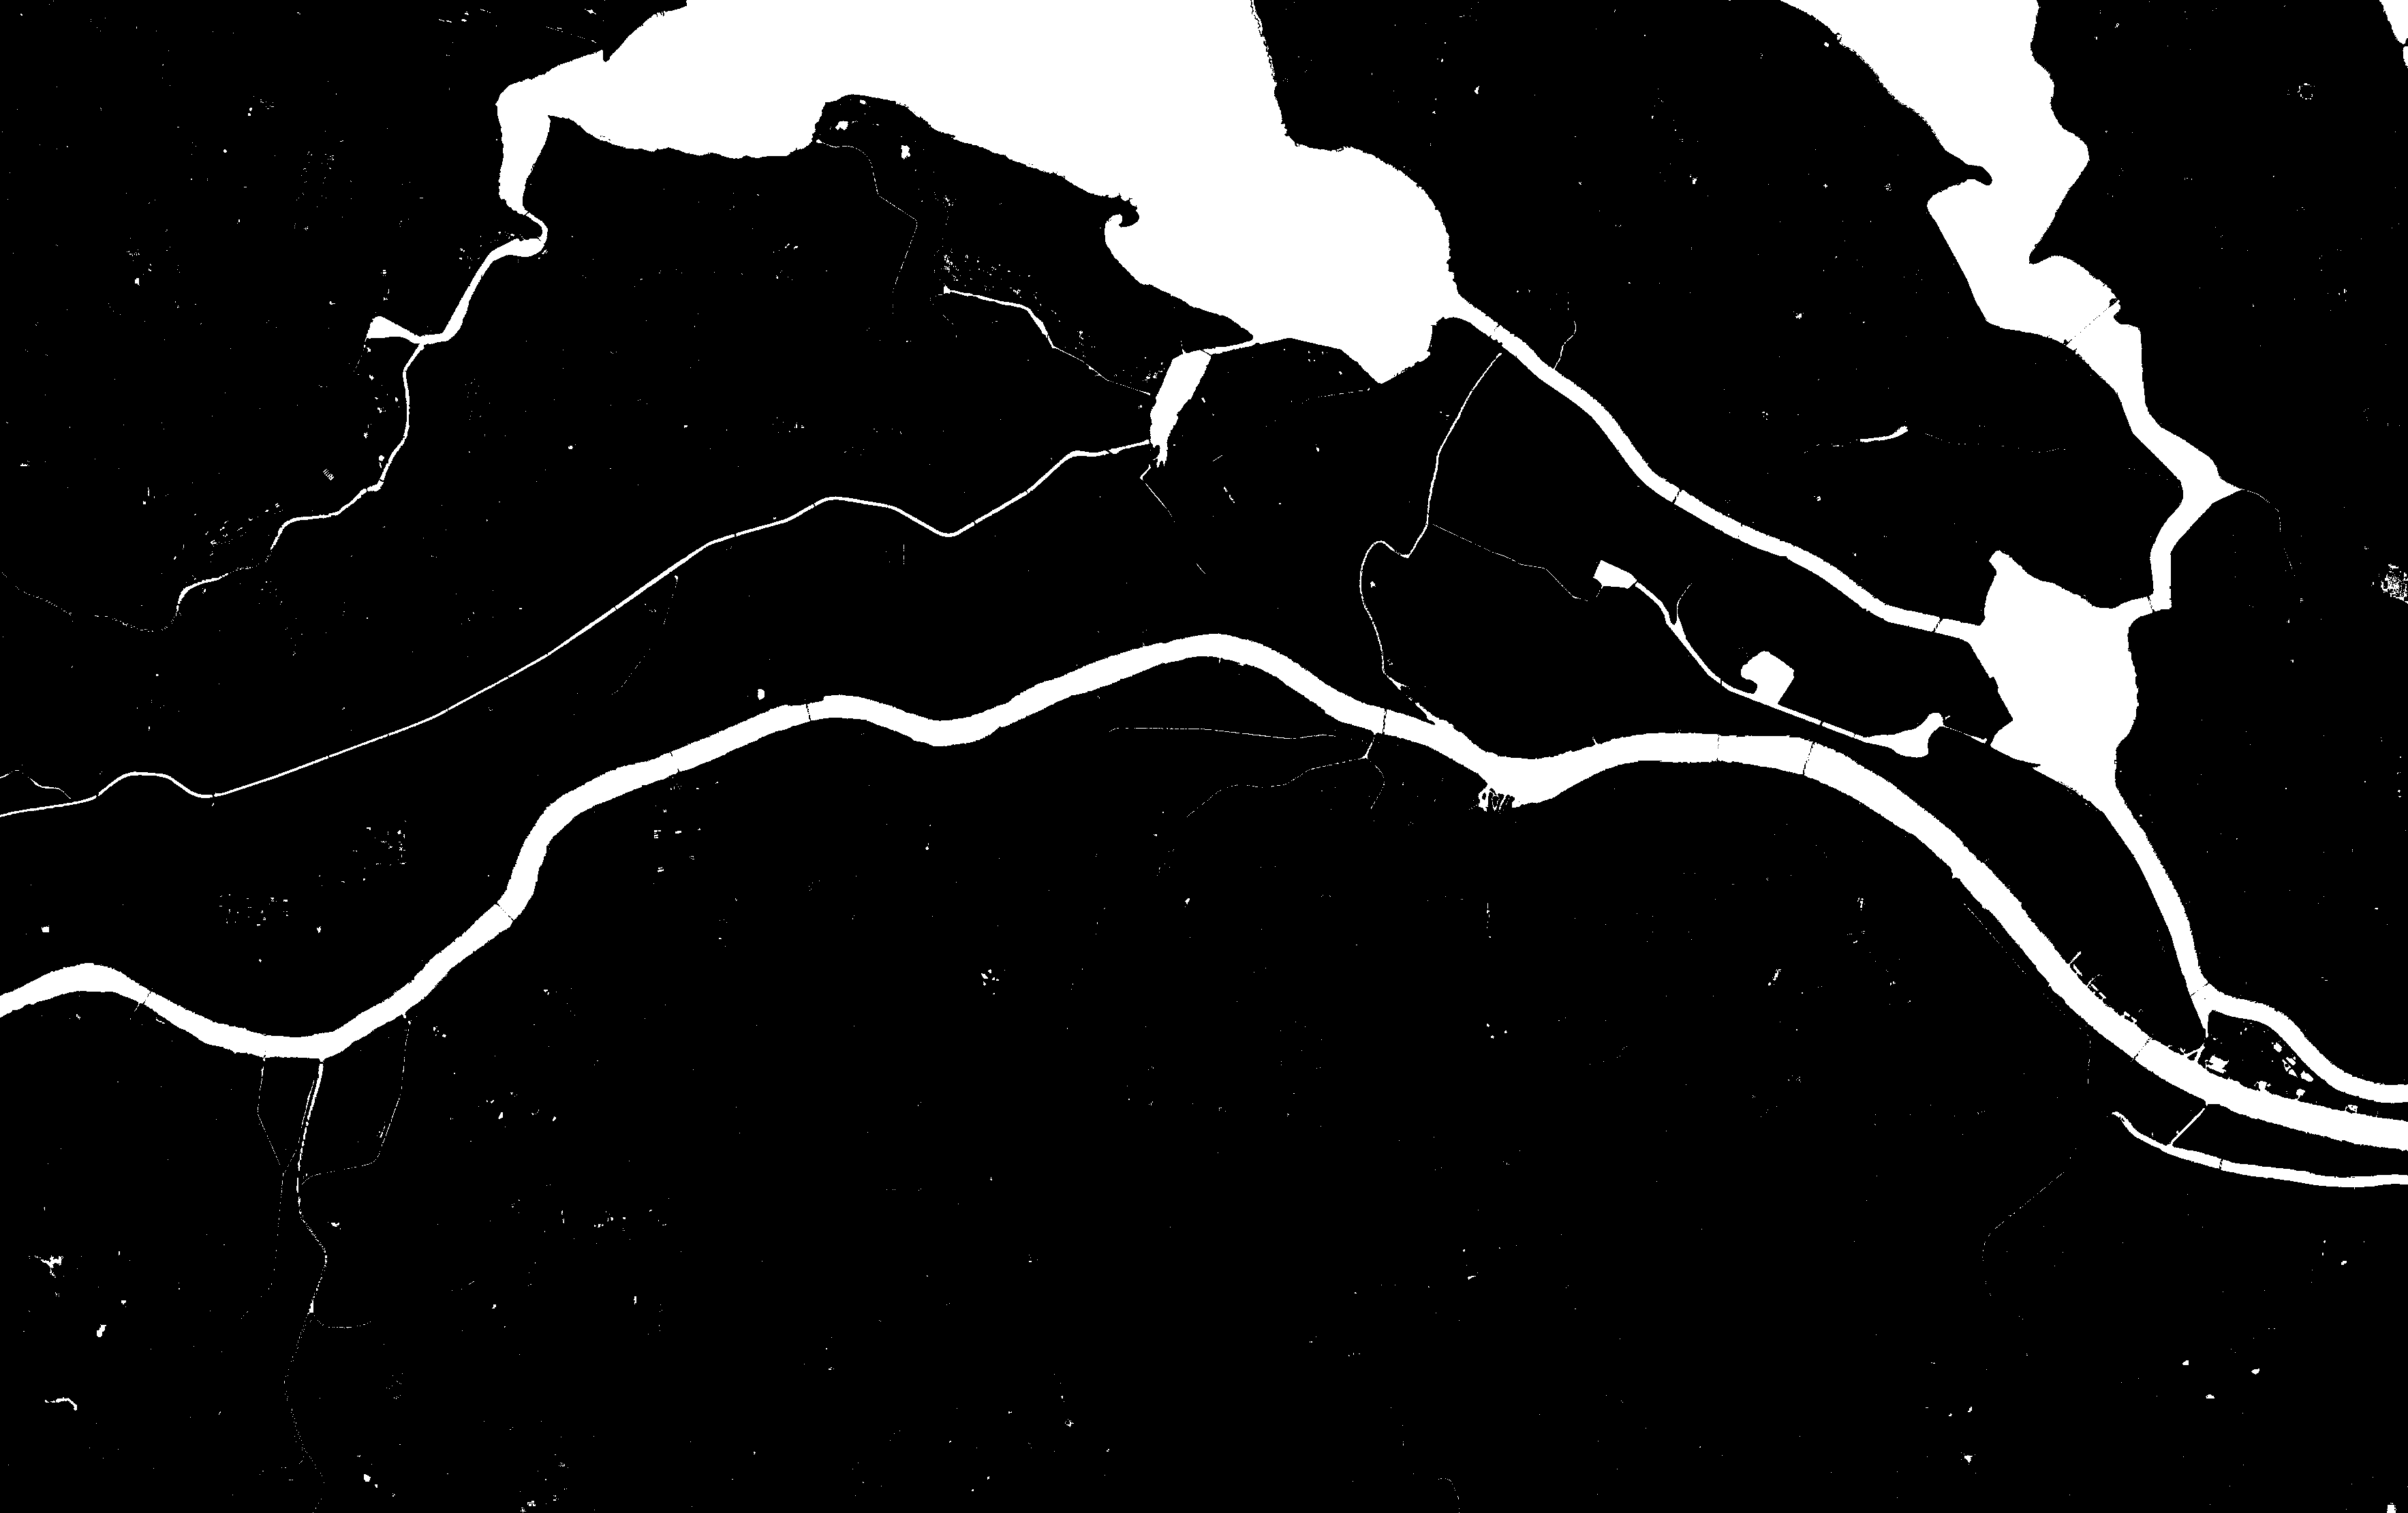

In [8]:
predicted_LULC_NN=[]
column_length=S2Image[0].shape[1]

for i in tqdm(range(S2Image[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(NumOfBands):
        spectrum_data_at_row_i.append(S2Image[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=np.transpose(model.predict_classes(spectrum_data_at_row_i_T))
    predicted_LULC_NN.append(predicted_class)

predicted_LULC_NN=np.array(predicted_LULC_NN).astype(np.uint8)

#To check the classification results, this code makes the binary image of the water class.
img=Image.fromarray(255*(predicted_LULC_NN==5).astype(np.uint8))
img

The output of the classification can be exported as a geotiff file. 

In [9]:
OutputFilePath="...\...\Classified_NN.tif"
with rio.open(OutputFilePath,'w',driver='GTiff',width=ReadBand.width,height=ReadBand.height,count=1,crs=ReadBand.crs,transform=ReadBand.transform,dtype=np.uint8) as output:
    output.write(predicted_LULC_NN,1)
    output.close()

Let's try Random Forest and Support Vector Machine!

In [10]:
#Random Forest

trainData_RF=np.array(trainData)
testData_RF=np.array(testData)
trainLabel_RF=keras.utils.to_categorical(trainLabel)
testLabel_RF=keras.utils.to_categorical(testLabel)

clf_RF=RandomForestClassifier(n_estimators=100)
clf_RF.fit(trainData_RF,trainLabel_RF)
pred_test=clf_RF.predict(testData_RF)
acc=np.sum(np.argmax(pred_test,axis=1)==np.argmax(testLabel_RF,axis=1))/(np.argmax(pred_test,axis=1).size)
print("The classification accuracy is {:.4f}".format(acc))

The classification accuracy is 0.8056


100%|██████████████████████████████████████████████████████████████████████████████| 2220/2220 [04:19<00:00,  8.56it/s]


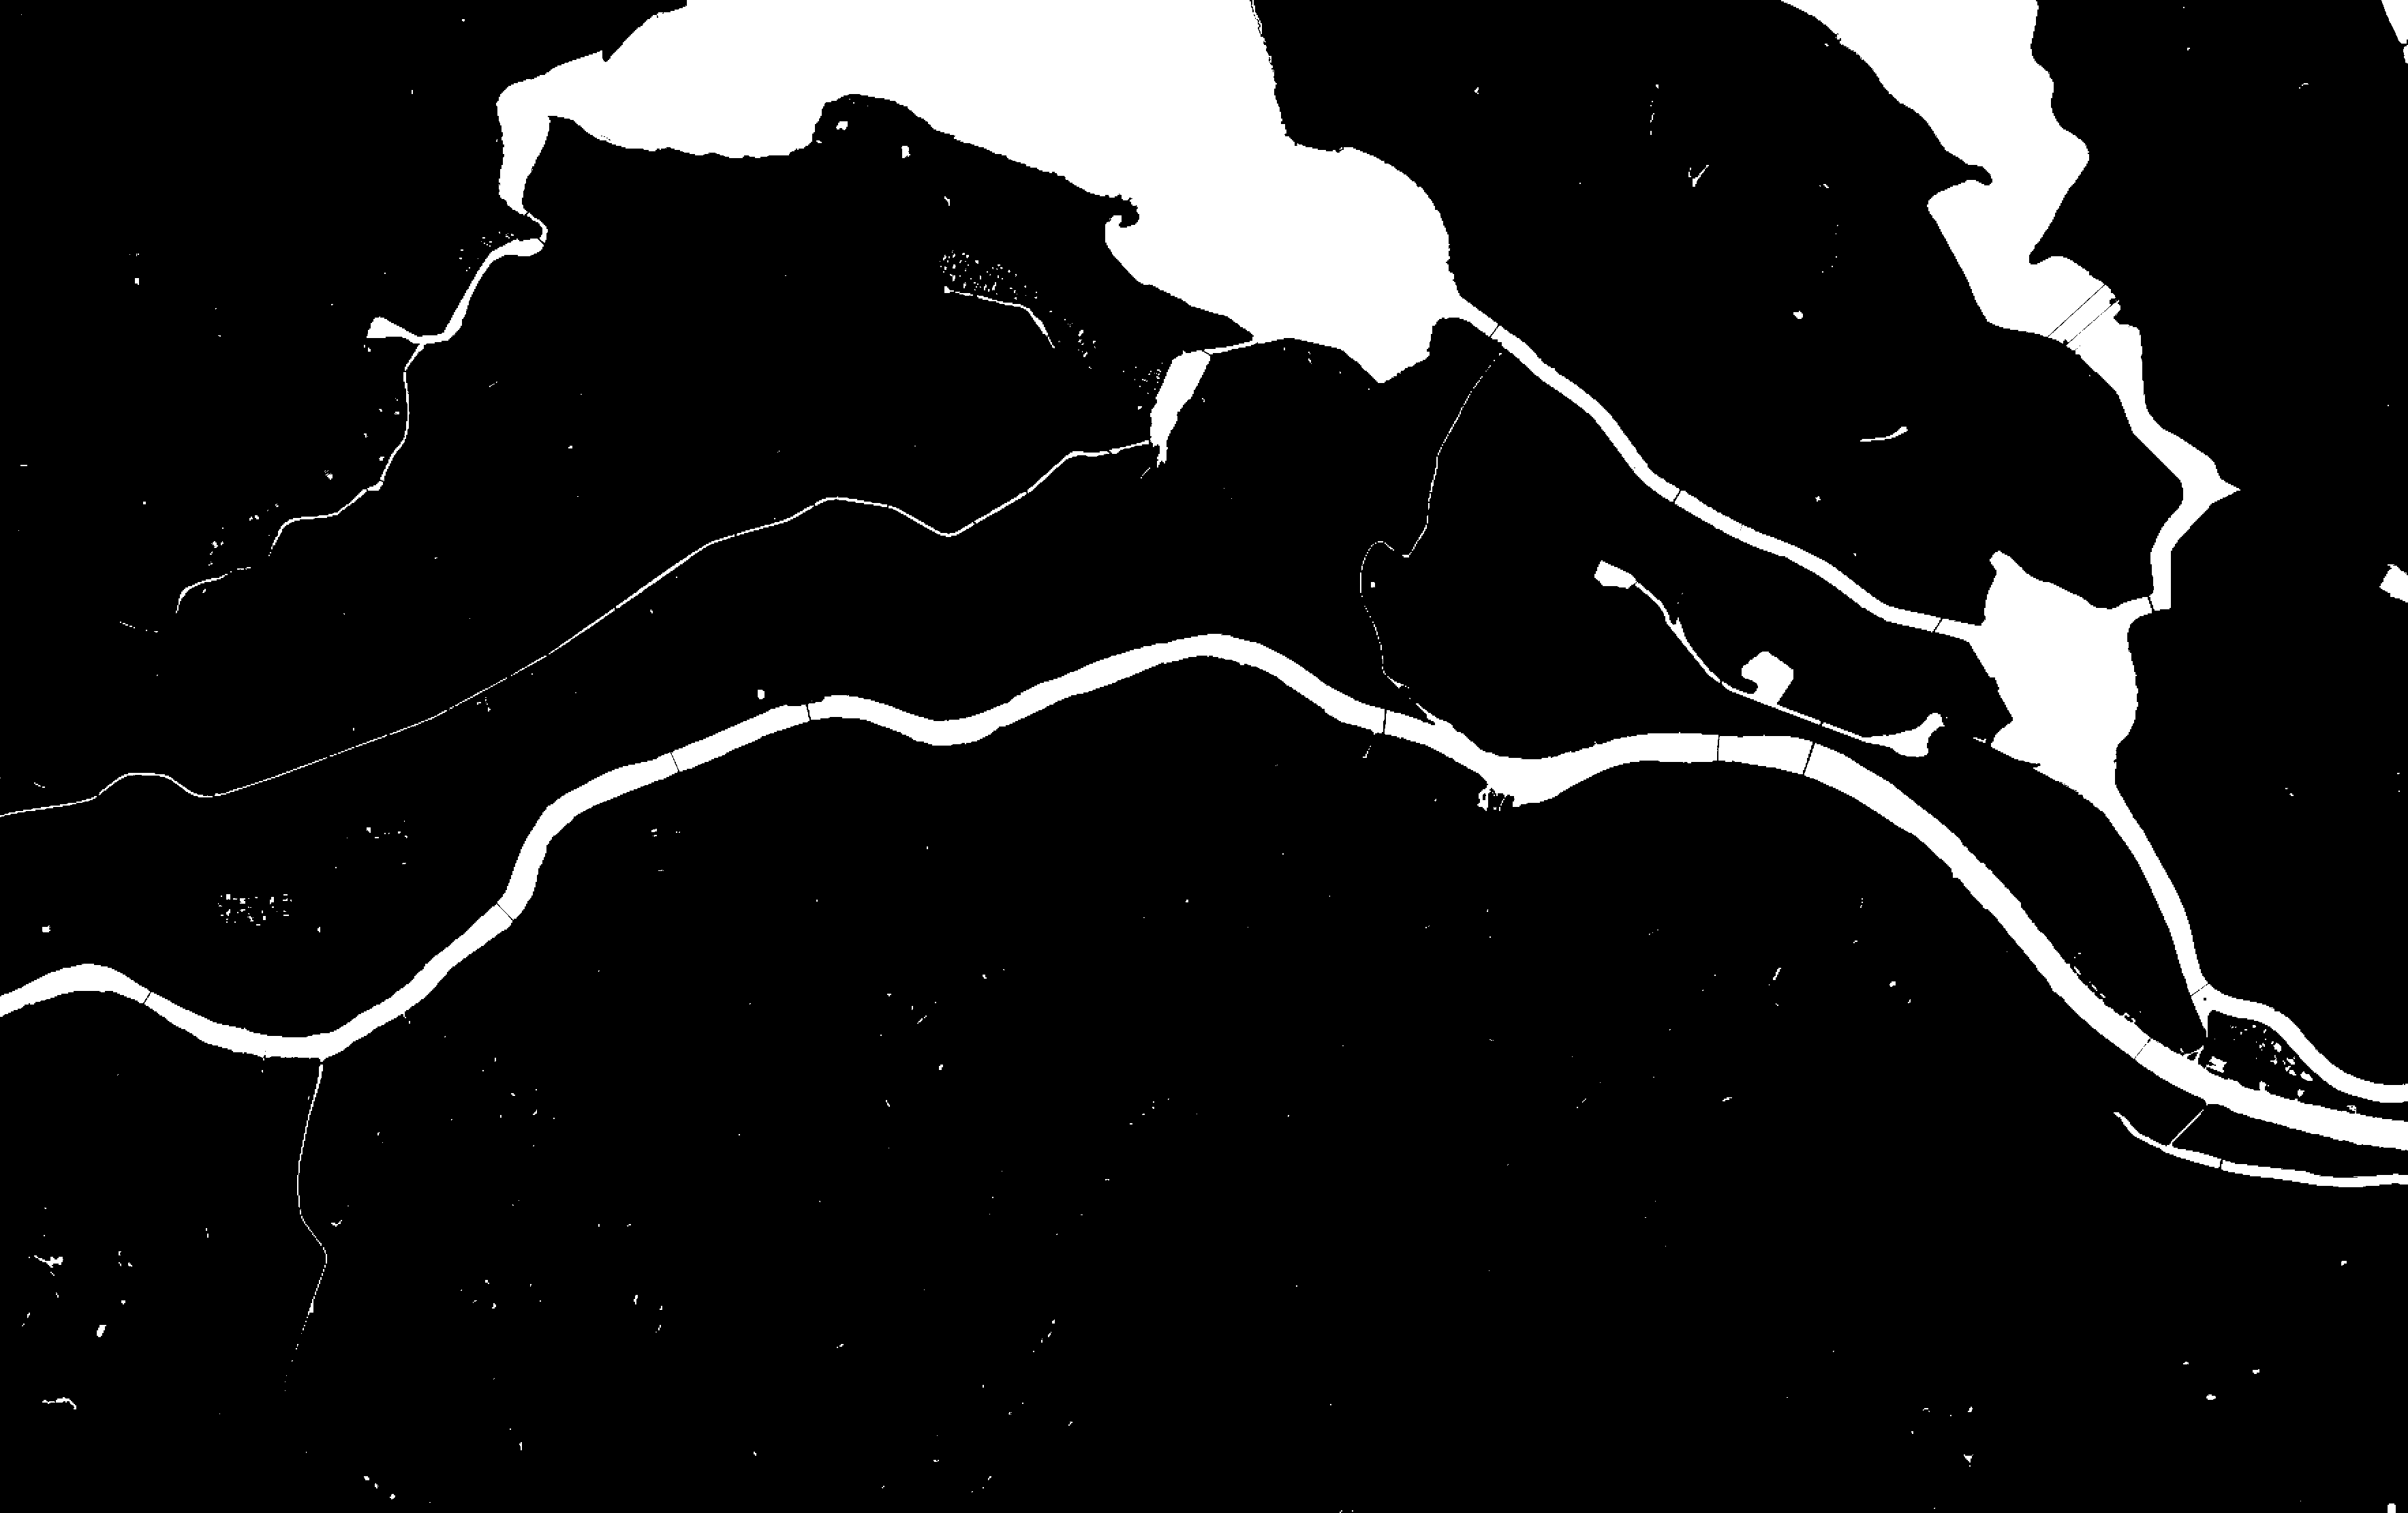

In [11]:
predicted_LULC_RF=[]
column_length=S2Image[0].shape[1]


for i in tqdm(range(S2Image[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(NumOfBands):
        spectrum_data_at_row_i.append(S2Image[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=clf_RF.predict(spectrum_data_at_row_i_T)
    predicted_LULC_RF.append(np.argmax(predicted_class,axis=1))

predicted_LULC_RF=np.array(predicted_LULC_RF).astype(np.uint8)

img=Image.fromarray(255*(predicted_LULC_RF==5).astype(np.uint8))
img

In [12]:
OutputFilePath="...\...\Classified_RF.tif"
with rio.open(OutputFilePath,'w',driver='GTiff',width=ReadBand.width,height=ReadBand.height,count=1,crs=ReadBand.crs,transform=ReadBand.transform,dtype=np.uint8) as output:
    output.write(predicted_LULC_RF,1)
    output.close()

In [13]:
#SVM 

trainData_SVM=np.array(trainData)
testData_SVM=np.array(testData)
trainLabel_SVM=trainLabel
testLabel_SVM=testLabel

clf_SVM = SVC()    
clf_SVM.fit(trainData_SVM, trainLabel_SVM)

pred_test= clf_SVM.predict(testData_SVM)
acc=np.sum(pred_test==testLabel_SVM)/(pred_test.size)
print("The classification accuracy is {:.4f}".format(acc))

The classification accuracy is 0.8125


100%|██████████████████████████████████████████████████████████████████████████████| 2220/2220 [04:24<00:00,  8.38it/s]


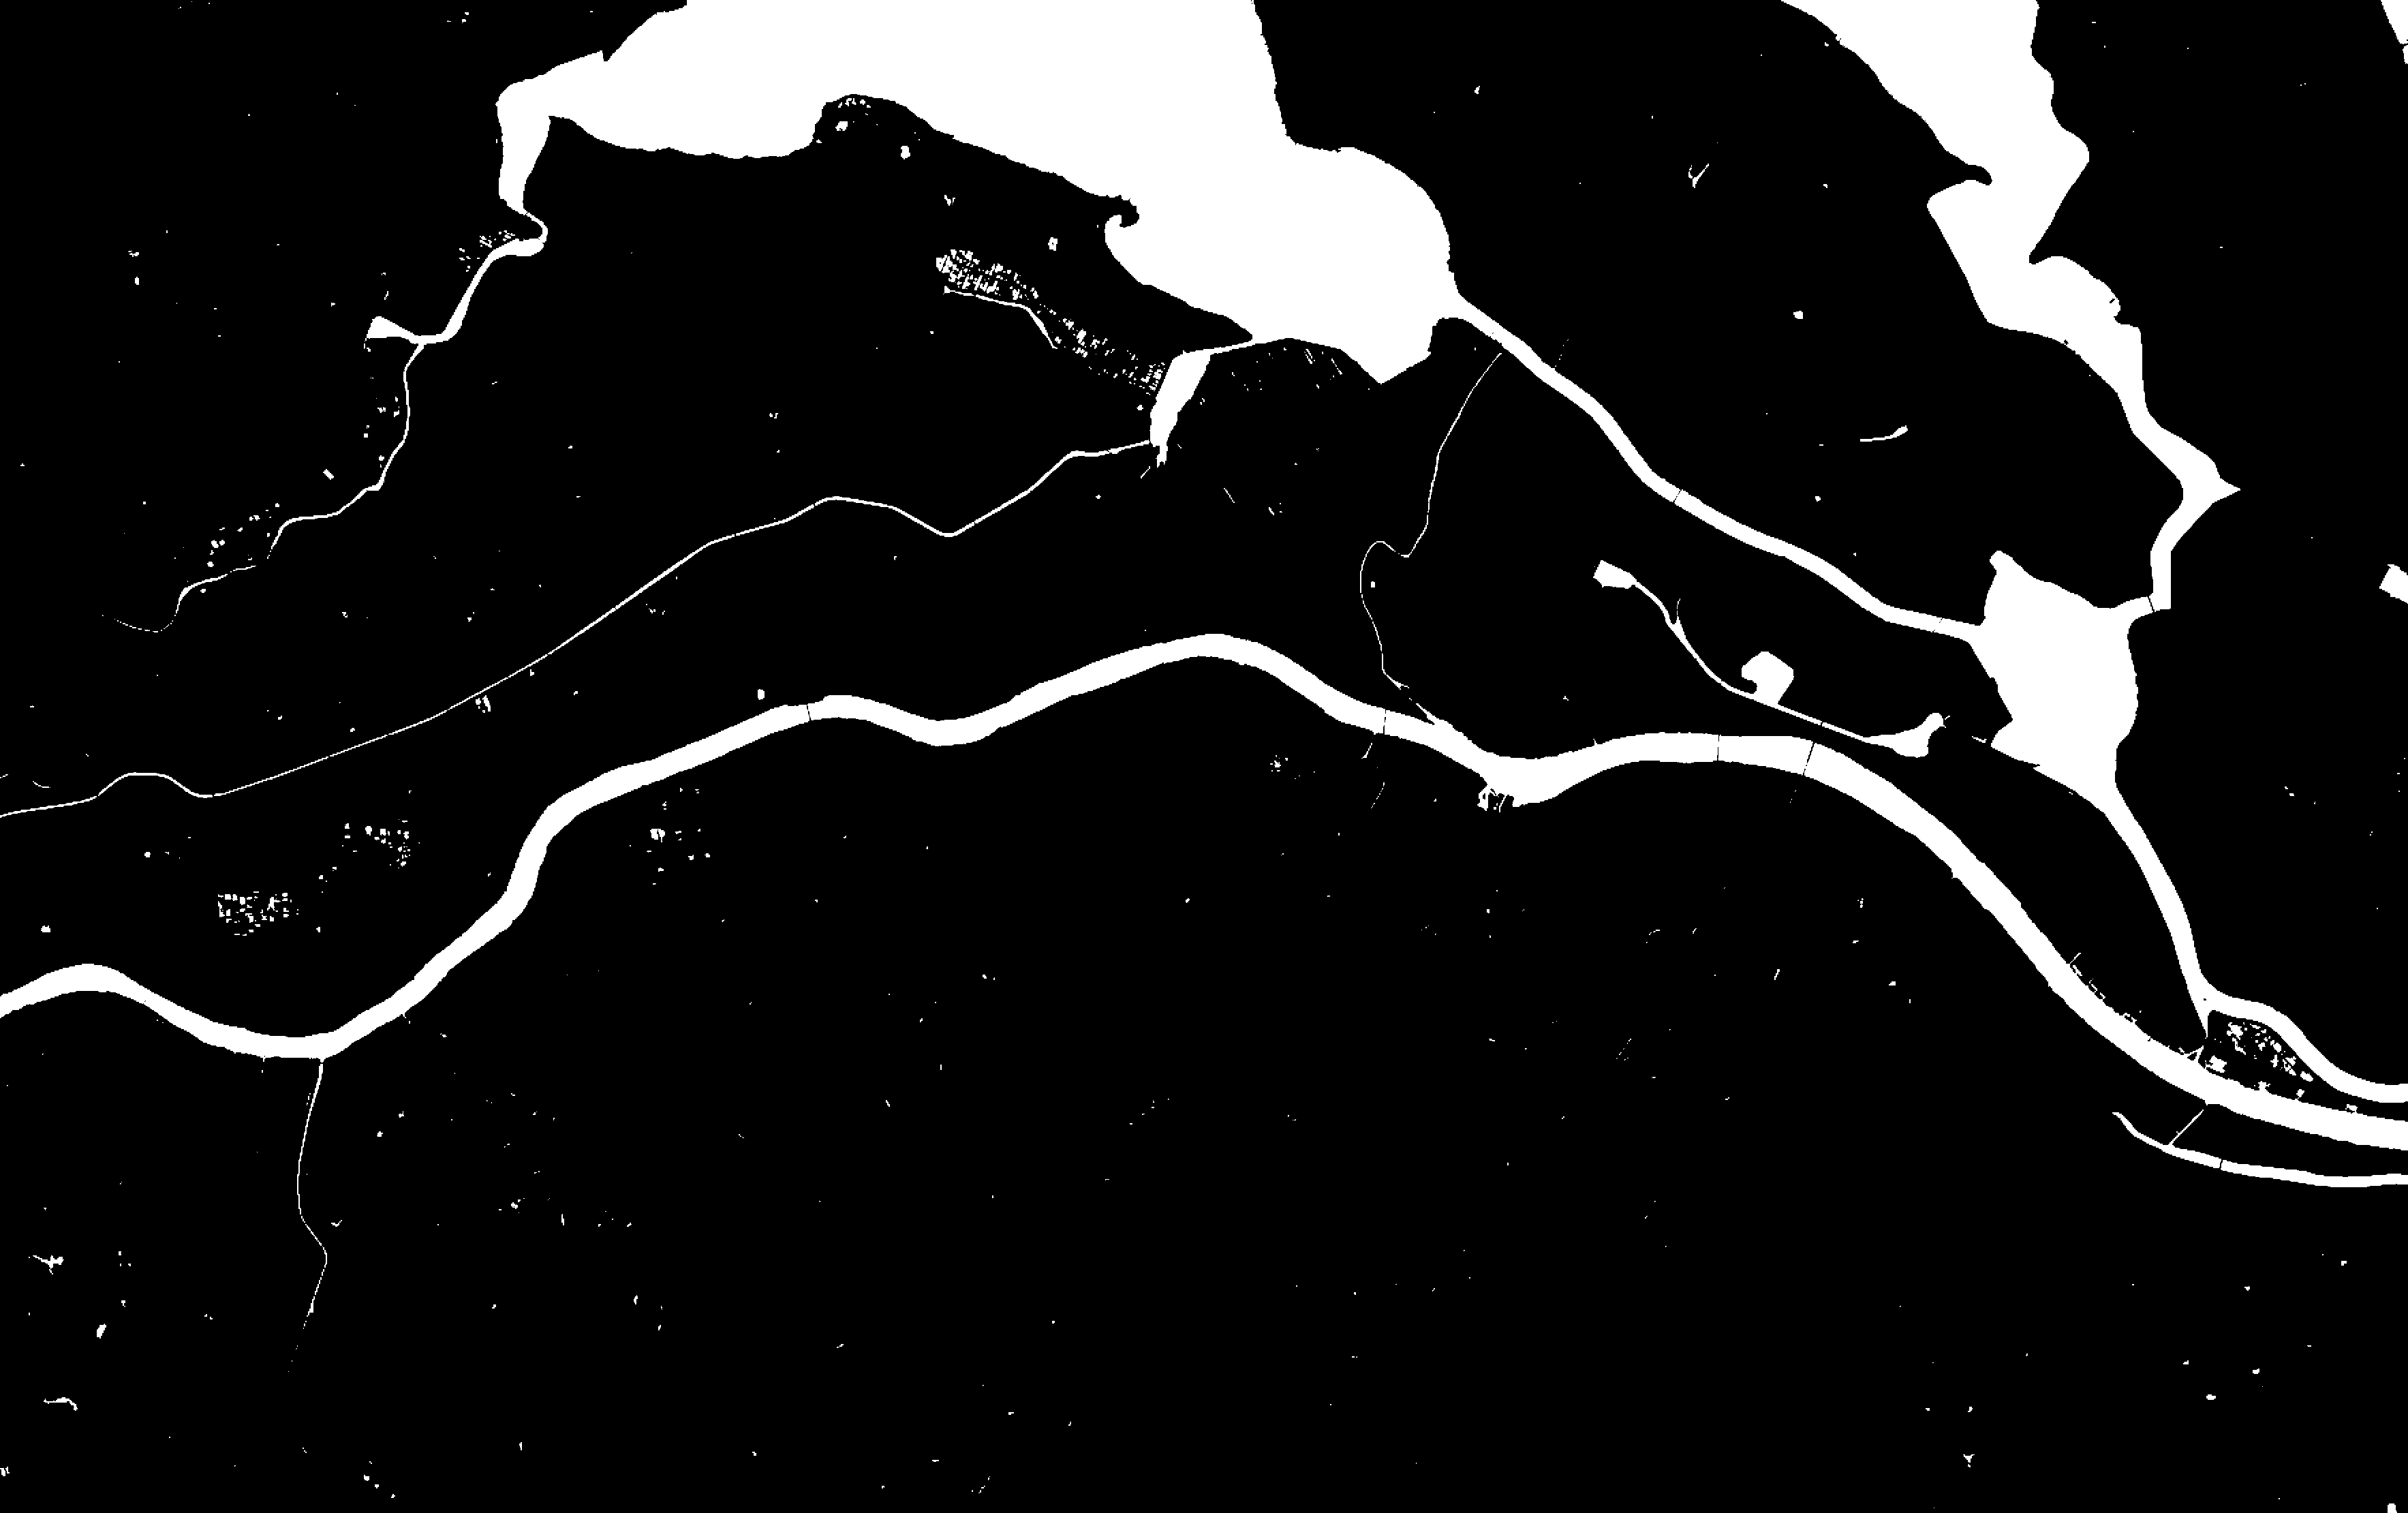

In [14]:
predicted_LULC_SVM=[]
column_length=S2Image[0].shape[1]


for i in tqdm(range(S2Image[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(NumOfBands):
        spectrum_data_at_row_i.append(S2Image[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=np.transpose(clf_SVM.predict(spectrum_data_at_row_i_T))
    predicted_LULC_SVM.append(predicted_class)

predicted_LULC_SVM=np.array(predicted_LULC_SVM).astype(np.uint8)

img=Image.fromarray(255*(predicted_LULC_SVM==5).astype(np.uint8))
img

In [15]:
OutputFilePath="...\...\Classified_SVM.tif"
with rio.open(OutputFilePath,'w',driver='GTiff',width=ReadBand.width,height=ReadBand.height,count=1,crs=ReadBand.crs,transform=ReadBand.transform,dtype=np.uint8) as output:
    output.write(predicted_LULC_SVM,1)
    output.close()